# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
from src.residual import get_volume_residual
import jax

import mrcfile

plt.rcParams["figure.figsize"]=6,6

### Read the data

In [3]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

#data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
#star_file = "/Extract/job018/particles.star"

data_dir = "/gpfs/gibbs/pi/lederman/3DFSC_data/tilted/Particle-Stack/"
star_file = "T40_HA_130K-Equalized_run-data.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  130000
load_data: data loaded, time:  68.10252213478088


In [4]:
print(imgs0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)

#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()

(130000, 256, 256)
(130000,)
(130000, 3)
(130000, 2)
(130000, 9)


### Only keep N points at random (to avoid out of memory error)

In [5]:
N = 2000 # imgs0.shape[0]
#idxrand = np.random.permutation(130000)[:N]
idxrand = np.random.permutation(N)[:N]

imgs0 = imgs0[idxrand]
pixel_size = pixel_size0[idxrand]
angles = angles0[idxrand]
shifts = shifts0[idxrand]
ctf_params = ctf_params0[idxrand]

### Some angle filtering

In [6]:
#idx = jnp.abs(angles0[:,2]) < jnp.pi/4
#imgs_f = imgs_f0[idx]
#pixel_size = pixel_size0[idx]
#angles = angles0[idx]
#shifts = shifts0[idx]
#ctf_params = ctf_params0[idx]

#idx2 = jnp.abs(angles[:,1]) < jnp.pi/3
#imgs_f = imgs_f[idx2]
#pixel_size = pixel_size[idx2]
#angles = angles[idx2]
#shifts = shifts[idx2]
#ctf_params = ctf_params[idx2]

#plot_angles(angles)

### Take the FFT of the images

In [7]:
t0 = time.time()
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs0])
print(time.time()-t0)

3.605469226837158


### Create the grids

In [8]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[2.981875e-03 2.560000e+02]


### Crop images to 32 x 32 

In [9]:
nx = 64
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[2.981875e-03 6.400000e+01]


### Before further processing, vectorize the images, create mask etc

In [10]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(2000, 4096)


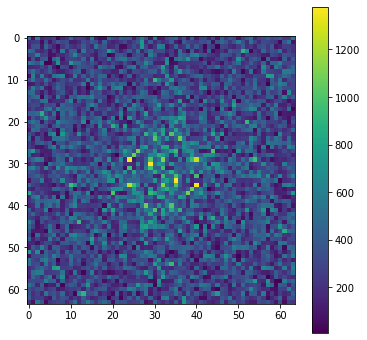

In [11]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[103].reshape(nx,nx)))); plt.colorbar()

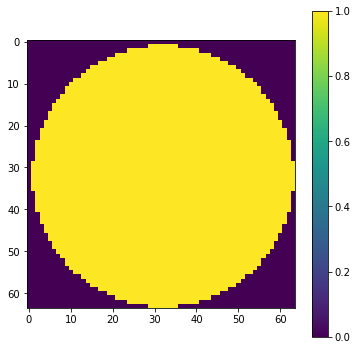

In [12]:
centre = (0,0,0)
#radius = 0.045 # for nx=32
#radius = 0.093 # nx-64
radius = 0.093
#radius = 0.07 # for nx=64
#radius = 0.198 # for nx=128
#radius = 0.28 # for nx=256

mask = create_3d_mask(x_grid, centre, radius)

mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Estimate the noise

First, decide on the dimensions of the empty corners to use for noise estimation:

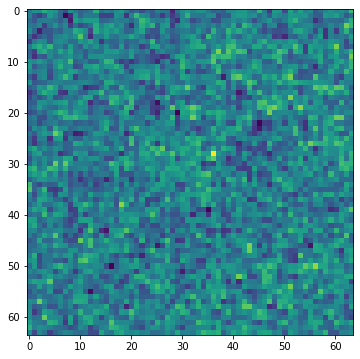

In [13]:
N_noise = 64
plt.imshow(jnp.mean(imgs0[:,:N_noise,:N_noise], axis=0))

Only use a small subset of the data for noise estimation so the kernel doesn't crash (possibly due to running out of memory)

Text(0.5, 1.0, 'Estimated noise')

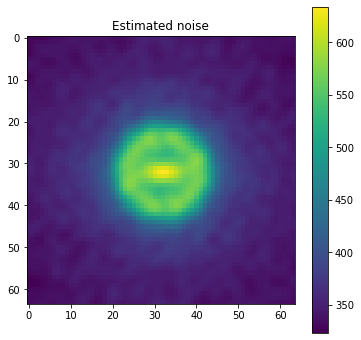

In [14]:
sigma_noise_estimated = estimate_noise_imgs(imgs0[:5000], nx_empty = N_noise, nx_final = nx).reshape([nx,nx])
plt.imshow(jnp.fft.fftshift(sigma_noise_estimated)); plt.colorbar()
plt.title('Estimated noise')

#### A quadratic noise model, fitted on the estimated one, for fun

Text(0.5, 1.0, 'Quadratic noise approximation')

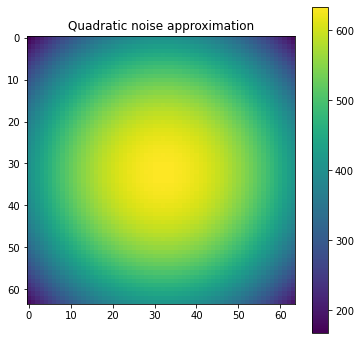

In [15]:
x_freq = jnp.fft.fftfreq(x_grid[1].astype(np.int64), 1/(x_grid[1] * x_grid[0]))
X,Y = jnp.meshgrid(x_freq, x_freq)
C = (jnp.max(sigma_noise_estimated)-jnp.min(sigma_noise_estimated))*1.5/jnp.max(X**2+Y**2)
sigma_noise_quadratic = jnp.max(sigma_noise_estimated) -(X**2 + Y**2)* C 
plt.imshow(jnp.fft.fftshift(sigma_noise_quadratic)); plt.colorbar()
plt.title('Quadratic noise approximation')

#### Average radially

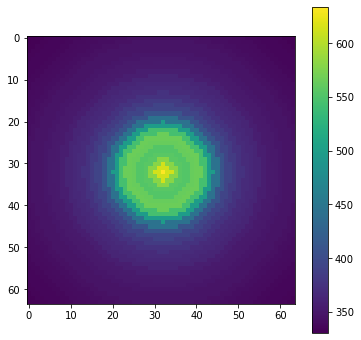

In [16]:
sigma_noise_avg = average_radially(sigma_noise_estimated, x_grid)

plt.imshow(jnp.fft.fftshift(sigma_noise_avg)); plt.colorbar()

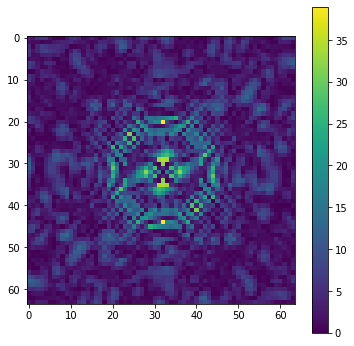

In [17]:
plt.imshow(jnp.fft.fftshift(jnp.abs(sigma_noise_avg-sigma_noise_estimated))); plt.colorbar()

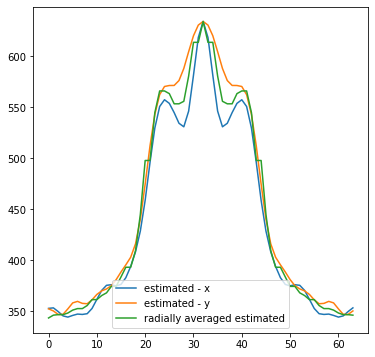

In [18]:
plt.plot(jnp.fft.fftshift(sigma_noise_estimated[:,0]))
plt.plot(jnp.fft.fftshift(sigma_noise_estimated[0,:]))
#plt.plot(jnp.fft.fftshift(sigma_noise_quadratic[:,0]))
plt.plot(jnp.fft.fftshift(sigma_noise_avg[:,0]))
#plt.legend(['estimated - x', 'estimated - y', 'quadratic', 'radially averaged estimated'])
plt.legend(['estimated - x', 'estimated - y', 'radially averaged estimated'])

In [19]:
sigma_noise = sigma_noise_avg.reshape(-1)

### Delete the real images
Since we only work with the Fourier ones from now on.

In [20]:
del(imgs0)
#del(imgs)

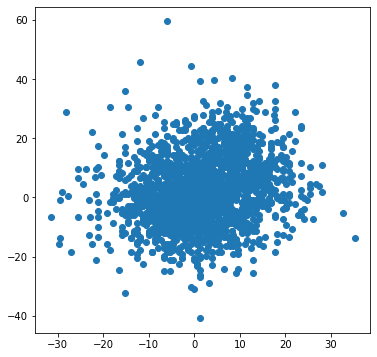

In [21]:
plt.scatter(shifts[:,0], shifts[:,1])

### Ab initio

In [ ]:
type(imgs_f)

In [ ]:
#old_stdout = sys.stdout
#sys.stdout = open('../data/relion/output.txt', 'w')

In [ ]:
#sys.stdout = sys.__stdout__

In [ ]:
#v_rec_int = v_rec
#angles_rec_int = angles_rec

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))


# The number of iterations desn't matter, 
# since it stops when the volume is nx x nx x nx.
N_samples = 40000
N_iter = 1000000


radius0 = 0.01
#radius0 = 0.03
alpha = 1e-9  # <--- this is the working one
#alpha = 1e-6

# The number of cg or sgd iterations also doesn't matter,
# since it stops when it reaches the desired accuracy.
N_cg_iter = 100000
eps_cg = 3e-5

N_sgd_iter = 100000
batch_size = 300
learning_rate = 1e6
#learning_rate = 1
eps_gd = 1e-8 
eps_gd = 2e-8
P = None

use_sgd = True

if use_sgd:
    N_vol_iter = N_sgd_iter
    eps_vol = eps_gd
else:
    N_vol_iter = N_cg_iter
    eps_vol = eps_cg

N_samples_angles = 1000 #21 #100
N_samples_vol = 21    

# HMC params
#dt = 5
dt_list = jnp.array([0.1, 0.5, 1, 5, 10])
L = 5

vol0 = None
angles0 = None
#sigma_noise = jnp.ones(sigma_noise.shape)
    
out_dir = '../data/3dfsc/'
imgs_f = imgs_f.reshape([N, nx*nx])

opt_vol_first = True

#v_rec, angles_rec = ab_initio(project, imgs_f, sigma_noise, shifts, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius0, None, alpha, eps_vol, 'tri', True, True, True, out_dir)
v_rec, angles_rec, angles_samples, angles_r, v_samples, v_r = ab_initio_mcmc(key, project, imgs_f, sigma_noise, shifts, ctf_params, x_grid, use_sgd, vol0, angles0, N_iter, learning_rate, batch_size, P, N_samples_angles, N_samples_vol, dt_list, L, radius0, None, alpha, eps_vol, 'tri', opt_vol_first, True, True, out_dir)



In [ ]:
plot_angles(angles_rec[:2000])

In [ ]:
plot_angles(angles[:2000])

In [ ]:
angles_r.shape

In [ ]:
plt.plot(angles_r[:,100])

In [ ]:
ae = angles_samples[:,3993,:]
ae.shape
plot_angles(ae)

In [ ]:
angles_samples.shape

In [ ]:
angles_samples[:,3993,:]

In [ ]:
plt.plot(ae[100:,1])

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_samples[0,:,:,0]))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_samples[20,:,:,0]))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(mask[:,:,0]))); plt.colorbar()

### Compare orientations

In [ ]:
get_rot_mat = lambda a : get_rotation_matrix(a[0], a[1], a[2])

In [ ]:
M = jax.vmap(get_rot_mat, in_axes=0)(angles)
M_rec = jax.vmap(get_rot_mat, in_axes=0)(angles_rec)

In [ ]:
# C3 symmetry rotations:
C1 = get_rotation_matrix(0,0,2*jnp.pi/3)
C2 = get_rotation_matrix(0,0,4*jnp.pi/3)

In [ ]:
err0 = jnp.sqrt(jnp.sum((M-M_rec)**2, axis=(1,2)))
err1 = jnp.sqrt(jnp.sum((M-M_rec*C1)**2, axis=(1,2)))
err2 = jnp.sqrt(jnp.sum((M-M_rec*C2)**2, axis=(1,2)))

In [ ]:
err = jnp.minimum(jnp.minimum(err0,err1), err2)

In [ ]:
theta = 2*jnp.arcsin(err/(2*jnp.sqrt(2)))

### MCMC vol

In [ ]:
plot_angles(angles[:2000])

In [ ]:
alpha = 1e-9
#alpha = 1e-6

#radius = 0.045 # for nx=32
radius = 0.0925
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128)
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()
M = 1/jnp.max(sigma_noise)**2 * jnp.ones([nx, nx, nx])

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)


logPi = lambda v : -loss_func_sum(v, angles, shifts, ctf_params, imgs_f, sigma_noise)
gradLogPi = lambda v : -jnp.conj(grad_loss_volume_sum(v, angles, shifts, ctf_params, imgs_f, sigma_noise))
#gradLogPi = lambda v : gradLogPi_split(v, angles_rec, shifts, ctf_params, imgs_f, sigma_noise, 10)


In [ ]:
N_mc_samples = 21
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

#v0 = (jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx)) )
v0 = jnp.zeros([nx,nx,nx])*1j
#v0 = v_rec
proposal_params_mala = {"tau" : 0.005}

dt_list = jnp.array([0.1, 0.5, 5, 10])
#dt_list = jnp.array([5])
proposal_params_hmc = {"dt_list" : dt_list, "L" : 10, "M" : M, "gradLogPi" : gradLogPi}

v_hmc_mean, r_hmc, v_hmc_samples = mcmc(key, N_mc_samples, proposal_hmc, logPi, v0, proposal_params_hmc)

In [ ]:
print(jnp.mean(r_hmc))
plt.plot(r_hmc)

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_hmc_samples[N_mc_samples-2,:,:,0]))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_hmc_mean[:,:,0]))); plt.colorbar()

In [ ]:
#plt.imshow(jnp.abs(jnp.fft.fftshift(v_rec[:,:,0]))); plt.colorbar()

In [ ]:
v_hmc_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_hmc_mean)))
mip_z(v_hmc_r)
plt.colorbar()

In [ ]:
with mrcfile.new('../data/reconstruction_data_v_hmc_mean_list_10_1e-9_ar.mrc', overwrite=True) as mrc:
    mrc.set_data(v_hmc_r.astype(np.float32))

In [ ]:
#import pickle
#file = open('../data/3dfsc64/angles_rec', 'wb')
#pickle.dump(angles_rec, file)
#file.close()

In [ ]:
with open('../data/3dfsc64/angles_rec', 'rb') as file:
    # Call load method to deserialze
    angles_rec2 = pickle.load(file)

In [ ]:
#jnp.sum(jnp.abs(angles_rec2 - angles_rec))

### MCMC orientations

In [ ]:
alpha0 = 0

radius = 0.4
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func0, loss_func_batched0, loss_func_sum0, _ = get_loss_funcs(slice_func, alpha = alpha0)
logPi_batch = lambda a : -loss_func_batched0(vol_fourier, a, shifts_true, ctf_params, imgs, 1)

### CG - choosing $\alpha$

In [ ]:
centre = (0,0,0)
#radius = 0.045
radius = 0.093
mask = create_3d_mask(x_grid, centre, radius)
mask2d = mask[:,:,0]

plt.imshow(jnp.fft.fftshift(mask2d)); plt.colorbar()

First, the slice function and the data fidelity function (i.e. the loss function with $\alpha=0$):

In [ ]:
slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
fid_func, fid_func_batched, fid_func_sum, _ = get_loss_funcs(slice_func, alpha = 0)

The noise

In [ ]:
print("sigma noise min =", jnp.min(sigma_noise))
print("sigma noise max =", jnp.max(sigma_noise))
print("sigma noise mean =", jnp.mean(sigma_noise))

#sigma_noise = jnp.max(sigma_noise)*jnp.ones(sigma_noise.shape)
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([nx,nx]))); plt.colorbar()

In [ ]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [ ]:
N_iter = 50100
eps = 1e-4
#eps = 1e-5
#eps = 1e-3
#eps = 1e-6
v0 = jnp.zeros([nx,nx,nx])* 1j
#alphas = [1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
#alphas = [1e-10, 1e-9, 1e-8]
alphas = [1e-8]
vcgs = []
fids = []
regs = []
losss = []
angles_cg = angles

In [ ]:
N_alpha = len(alphas)
for alpha in alphas[:N_alpha]:
    t0 = time.time()
    print('alpha =', alpha)
    
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
    grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)
    
    AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles_cg, shifts, ctf_params, imgs_f_m, v0.shape, sigma_noise)
    vcg, _ = conjugate_gradient(AA, Ab, v0, N_iter, eps, verbose = True)
    
    fid = 2*fid_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vcg)/(nx*nx*nx)
    loss = loss_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vcgs.append(vcg)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vcgs = jnp.array(vcgs)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

In [ ]:
plt.semilogx(alphas, fids)
plt.semilogx(alphas, regs)
plt.semilogx(alphas, losss)
plt.legend(['fid', 'reg', 'fid+reg'])

In [ ]:
plt.plot(fids)

In [ ]:
plt.semilogy(regs)

Pixel-wise loss for the best reconstruction:

In [ ]:
mask.shape

In [ ]:
def pixel_wise_fid_fun(v, slice_func_array, angles, shifts, ctf_params, imgs, sigma):
    err = slice_func_array(v, angles, shifts, ctf_params) - imgs
    return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/(2*sigma**2)
    #return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/2

In [ ]:
alphas[alpha_idx]

In [ ]:
sigma_noise1 = jnp.ones(sigma_noise.shape)

In [ ]:
pw_fid = pixel_wise_fid_fun(vcgs[0], slice_func_array, angles, shifts, ctf_params, imgs_f_m, sigma_noise1)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()

Pixel-wise loss for the ZERO volume:

In [ ]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(v0.shape), slice_func_array, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise1)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()

In [ ]:
alpha_idx = jnp.argmin(fids)
print(alpha_idx)

In [ ]:
#alpha_idx = 2

In [ ]:
print(alphas[alpha_idx])
plt.imshow(jnp.abs(jnp.fft.fftshift(vcgs[alpha_idx][:,0,:]))); plt.colorbar()

In [ ]:
img_idx = 100
s0 = slice_func(vcgs[alpha_idx], angles_cg[img_idx], shifts[img_idx], ctf_params[img_idx])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(s0 - imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

In [ ]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
vcg_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcgs[alpha_idx])))
mip_z(vcg_r)
plt.colorbar()
plt.title('Reconstruction MIP')


In [ ]:
with mrcfile.new('../data/reconstruction_data_32_cg_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vcg_r.astype(np.float32))

### All images are the same, with different scalings (corresponding to different orders of $\alpha$)

In [ ]:
vcgs_s = vcgs[:,:,0,0]
vcgs_s.shape

In [ ]:
plt.plot(jnp.abs(vcgs_s[0]))
plt.plot(jnp.abs(vcgs_s[1])*9)
plt.plot(jnp.abs(vcgs_s[2])*90)
plt.plot(jnp.abs(vcgs_s[3])*900)
plt.plot(jnp.abs(vcgs_s[6])*9e5)
plt.plot(jnp.abs(vcgs_s[8])*9e7)
plt.plot(jnp.abs(vcgs_s[10])*9e8)

### FSC, orientations, standard deviation for each voxel etc

In [ ]:
vcg1 = vcgs[0]
vcg2 = vcgs[6]

In [ ]:
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid)

In [ ]:
points_v_tri = points_orientations_tri(angles, x_grid[1].astype(jnp.int64), number_of_batches = 1000)
#points_v_nn = points_orientations_nn(angles[:1000], x_grid[1])

In [ ]:
plt.imshow(jnp.fft.fftshift(points_v_tri[:,:,0])); plt.colorbar()

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA(vones)
omega = 1/omega

In [ ]:
jnp.min(jnp.abs(omega))

In [ ]:
plt.title("Standard deviation")
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))); plt.colorbar()

### SGD

### Preconditioner

In [ ]:
P = get_preconditioner(x_grid) * mask
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
#P = jnp.sqrt(P)
P = P**0.15
P = P /jnp.max(P)+ 1e-6
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### Points/orientations preconditioner

In [ ]:
P = points_v_tri +1
P = 1/P * mask + 1e-12
P = P/jnp.max(P) * mask
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### $\alpha$ tuning

In [ ]:
mask2d = mask[:,:,0]
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [ ]:
N_epoch = 501000
batch_size = 300
#learning_rate = 100000
learning_rate = 10000 * 100
#learning_rate = 10000 # for "large" alpha

P = None

#eps = 3e-5
#eps = 1e-3
#eps = 1e-9
eps = 1e-8
v0 = jnp.zeros([nx,nx,nx])* 1j
#alphas = 1/100 * jnp.array([1e-9, 1e-8, 1e-7, 1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]) #, 1e0, 1e1, 1e2, 1e3]
#alphas = [1e-10, 1e-9, 1e-8, 1e-7]
alphas = [1e-9]

angles_gd = angles

In [ ]:
vgds = []
fids = []
regs = []
losss = []

#N_alpha = 4
for alpha in alphas:
    t0 = time.time()
    print('alpha =', alpha)
    
    slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

    grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

    sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_sum, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
    
    vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, P, eps, verbose = True)
    
    fid = 2*fid_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vgd)/(nx*nx*nx)
    loss = loss_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vgds.append(vgd)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

In [ ]:
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

N_alpha= len(fids)

In [ ]:
plt.semilogx(alphas[:N_alpha], fids)
plt.semilogx(alphas[:N_alpha], regs)
plt.semilogx(alphas[:N_alpha], losss)
plt.legend(['fid', 'reg', 'fid+reg'])

In [ ]:
plt.plot(fids)

In [ ]:
plt.semilogy(regs)

In [ ]:
alphas[2]

In [ ]:
#alpha_idx= 3
#alpha_idx=5
#alpha_idx=0

In [ ]:
pw_fid = pixel_wise_fid_fun(vgds[alpha_idx], slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

In [ ]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(vgd.shape), slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vgds[alpha_idx,:,0,:]))); plt.colorbar()

In [ ]:
#plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:,0,:]))); plt.colorbar()

In [ ]:
#err = vgds[1] - v_rec
#plt.imshow(jnp.fft.fftshift((jnp.abs(err[:,0,:]))*mask[:,0,:])); plt.colorbar()

In [ ]:
vgds_s = vgds[:,:,0,0]
vgds_s.shape

plt.plot(jnp.abs(vgds_s[0]))
plt.plot(jnp.abs(vgds_s[1])*1.1)
plt.plot(jnp.abs(vgds_s[2])*2)
plt.plot(jnp.abs(vgds_s[3])*7)


In [ ]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgds[alpha_idx])))
mip_z(vr_sgd)
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
with mrcfile.new('../data/reconstruction_data_32_sgd_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))

In [ ]:
idx = 100

In [ ]:
slicegd = slice_func(vgds[alpha_idx], angles_gd[idx], shifts[idx], ctf_params[idx])
#slicerec = slice_func(v_rec, angles_gd[idx], shifts[idx], ctf_params[idx])

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicegd.reshape([nx,nx])))); plt.colorbar()

In [ ]:
#plt.imshow(jnp.abs(jnp.fft.fftshift(slicerec.reshape([32,32])))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(imgs_f[idx].reshape([nx,nx])))); plt.colorbar()

### C3 Symmetry

In [115]:
def split(arr):
    N = arr.shape[0]
    N2 = jnp.floor(N/2).astype(jnp.int32)

    arr_train = arr[:N2]
    arr_test  = arr[N2:]
    
    return arr_train, arr_test

def split_and_triple(arr):
    N = arr.shape[0]
    N2 = jnp.floor(N/2).astype(jnp.int32)

    arr_train = jnp.tile(arr[:N2], reps=(3,1))
    arr_test  = jnp.tile(arr[N2:], reps=(3,1))
    
    return arr_train, arr_test

def split_and_triple_angles(a):
    N = a.shape[0]
    N2 = jnp.floor(N/2).astype(jnp.int32)

    a_train1 = a[:N2]
    a_train2 = a_train1.copy()
    a_train3 = a_train1.copy()

    a_train2[:,2] += 2*jnp.pi/3
    a_train3[:,2] += 4*jnp.pi/3
   
    a_train = jnp.concatenate([a_train1, a_train2, a_train3], axis=0)
    
    a_test1  = a[N2:]
    a_test2 = a_test1.copy()
    a_test3 = a_test1.copy()

    a_test2[:,2] += 2*jnp.pi/3
    a_test3[:,2] += 4*jnp.pi/3
    
    a_test = jnp.concatenate([a_test1, a_test2, a_test3], axis=0)


    return a_train, a_test

In [119]:
imgs_train, imgs_test = split_and_triple(imgs_f)
shifts_train, shifts_test = split_and_triple(shifts)
ctf_params_train, ctf_params_test = split_and_triple(ctf_params)
angles_train, angles_test = split_and_triple_angles(angles)
N = imgs_train.shape[0]

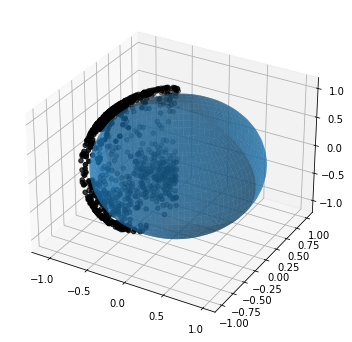

In [120]:
plot_angles(angles[:1000])

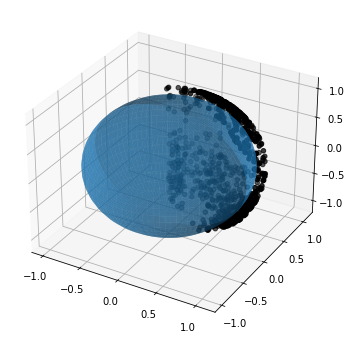

In [121]:
plot_angles(angles_train[1000:2000])

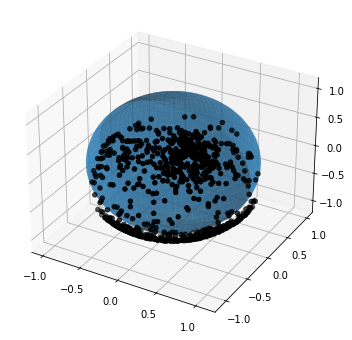

In [122]:
plot_angles(angles_train[2000:3000])

In [ ]:
#imgs_train, imgs_test = split(imgs_f)
#shifts_train, shifts_test = split(shifts)
#ctf_params_train, ctf_params_test = split(ctf_params)
#angles_train, angles_test = split(angles)
#N = imgs_train.shape[0]
#plot_angles(angles_train)

### Volume residual

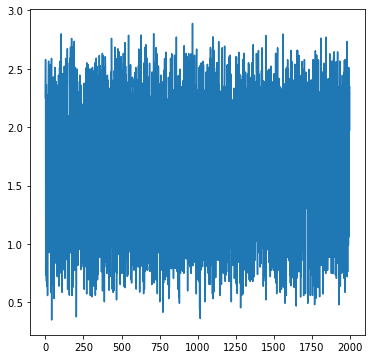

In [26]:
plt.plot(angles[:,1])

In [126]:
p1 = np.random.randn(N) * 0 #np.pi/20
p2 = np.random.randn(N) * 0 #np.pi/40 + np.pi/2
p3 = np.random.randn(N) * np.pi/10

angles_train_pert = angles_train + jnp.array([p1,p2,p3]).transpose()

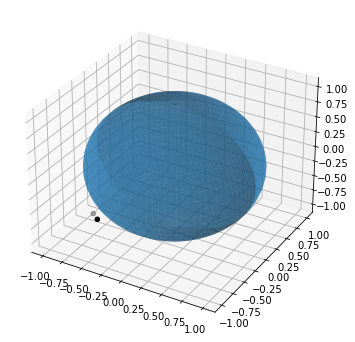

In [127]:
idx = 100
aa = jnp.array([angles_train[idx], angles_train_pert[idx]])
plot_angles(aa)

In [128]:
angles_rec = angles_train
#angles_rec = angles_train_pert

In [129]:
alpha = 1e-9
N_train = jnp.floor(N/2).astype(jnp.int32) #3000

radius = 0.0925
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()
M = 1/jnp.max(sigma_noise)**2 * jnp.ones([nx, nx, nx])

slice_func, slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

logPi = lambda v : -loss_func_sum(v, angles_rec, shifts_train, ctf_params_train, imgs_train, sigma_noise)
gradLogPi = lambda v : -jnp.conj(grad_loss_volume_sum(v, angles_rec, shifts_train, ctf_params_train, imgs_train, sigma_noise))


In [130]:
N_mc_samples = 101
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

v0 = jnp.zeros([nx,nx,nx])*1j
dt_list = jnp.array([0.01, 0.1, 0.5, 5, 10])
proposal_params_hmc = {"dt_list" : dt_list, "L" : 10, "M" : M, "gradLogPi" : gradLogPi}

t0 = time.time()
v_rec, r_hmc, v_hmc_samples = mcmc(key, N_mc_samples, proposal_hmc, logPi, v0, proposal_params_hmc)
print(time.time()-t0)

  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 2022.1112242290715
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 2020.0428952779353
  Iter 60 , a =  1.0
  MC sample 60 , loss (of mean) = 2018.5516945332927
  Iter 80 , a =  1.0
  MC sample 80 , loss (of mean) = 2018.0270921918836
  Iter 100 , a =  2.889547121914435e-51
  MC sample 100 , loss (of mean) = 2017.8034084681356
181.95962190628052


In [131]:
N

3000

0.84


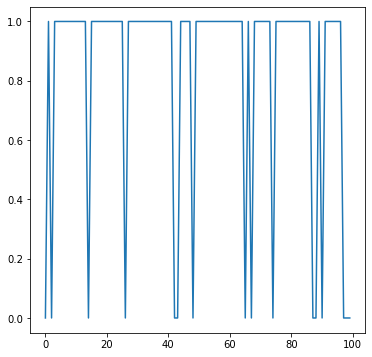

In [132]:
print(jnp.mean(r_hmc))
plt.plot(r_hmc)

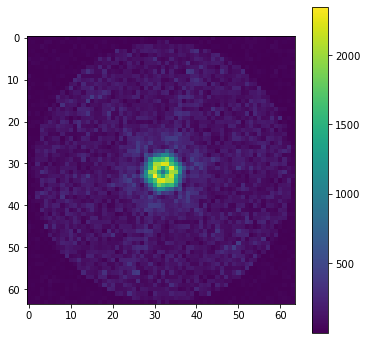

In [133]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_rec[:,:,0]))); plt.colorbar()

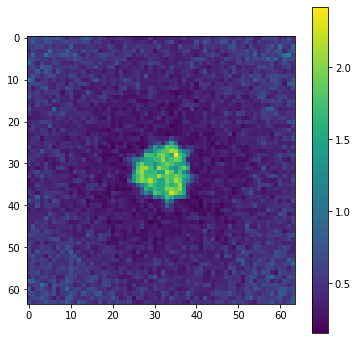

In [134]:
v_rec_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(v_rec_r)
plt.colorbar()

In [137]:
with mrcfile.new('../data/3dfsc/v_rec_vol_hmc_64_triple.mrc', overwrite=True) as mrc:
    mrc.set_data(v_rec_r.astype(np.float32))

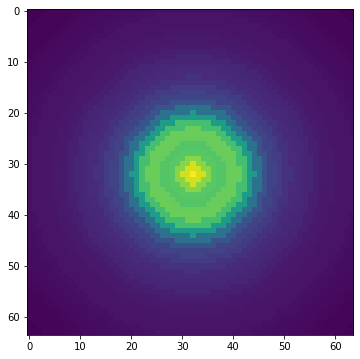

In [138]:
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([64,64])))

In [ ]:
N_batches = 60000 
#v_resid = get_volume_residual(v_rec, angles[N_train:N_train+2000], shifts[N_train:N_train+2000], ctf_params[N_train:N_train+2000], imgs_f[N_train:N_train+2000], sigma_noise, x_grid, slice_func_array, N_batches)
v_resid = get_volume_residual(v_rec, angles_test, shifts_test, ctf_params_test, imgs_test, sigma_noise, x_grid, slice_func_array, N_batches)
                          

 43%|████▎     | 25636/60000 [01:12<01:20, 426.86it/s]

In [ ]:
v_resid_zero = get_volume_residual(jnp.zeros(v_rec.shape), angles_test, shifts_test, ctf_params_test, imgs_test, sigma_noise, x_grid, slice_func_array, N_batches)


In [ ]:
jnp.sum(v_resid/(64*64*64))

In [ ]:
plt.imshow(jnp.fft.fftshift(v_resid[:,:,0]*mask[:,:,0])); plt.colorbar()

In [ ]:
plt.imshow(jnp.fft.fftshift(v_resid_zero[:,:,0]*mask[:,:,0])); plt.colorbar()

In [141]:
v_resid_print = jnp.fft.fftshift(v_resid_zero*mask)
with mrcfile.new('../data/relion/v_resid_64_zero.mrc', overwrite=True) as mrc:
    mrc.set_data(v_resid_print.astype(np.float32))

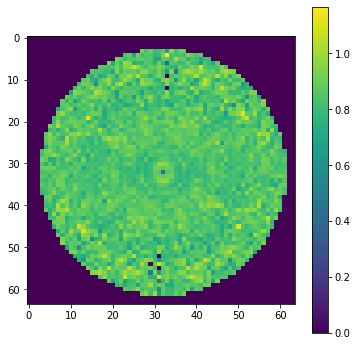

In [117]:
plt.imshow(jnp.fft.fftshift(v_resid_train[:,:,0]*mask[:,:,0])); plt.colorbar()

In [131]:
v_resid_m = jnp.fft.fftshift(v_resid*mask)
v_resid_pert_m = jnp.fft.fftshift(v_resid_pert*mask)
v_resid_zero_m = jnp.fft.fftshift(v_resid_zero*mask)


In [134]:
print(jnp.max(v_resid_m))
print(jnp.max(v_resid_pert_m))
print(jnp.max(v_resid_zero_m))
plot_vmax = jnp.max(jnp.array([v_resid_m, v_resid_pert_m, v_resid_zero_m]))
print(plot_vmax)

1.5240442049932772
1.5536615436980803
1.5854856945421179
1.5854856945421179


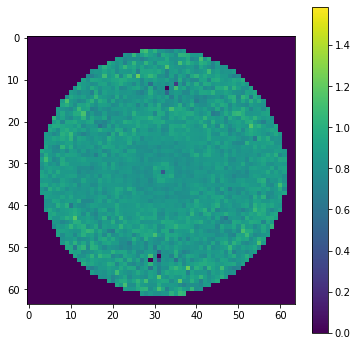

In [138]:

plt.imshow(v_resid_m[:,:,32], vmin=0, vmax=plot_vmax)
plt.colorbar()
#plt.title('True angles')

#plt.savefig('v_resid_slice.png')

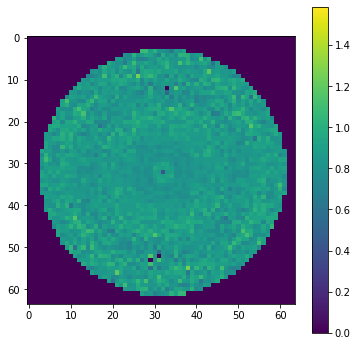

In [139]:
plt.imshow(v_resid_pert_m[:,:,32], vmin=0, vmax=plot_vmax)
plt.colorbar()
#plt.title('Perturbed angles')
#plt.savefig('v_resid_pert_slice.png')

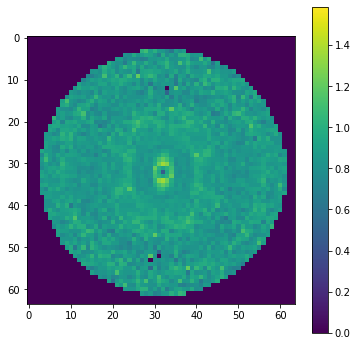

In [140]:
plt.imshow(v_resid_zero_m[:,:,32], vmin=0, vmax=plot_vmax)
plt.colorbar()
#plt.title('Perturbed angles')
#plt.savefig('v_resid_zero_slice.png')

### Plots

### Separate the projection step

In [ ]:
# Force garbage collection when it throws OOM on GPU for small amount.
#import gc
#gc.collect()

In [ ]:
from src.residual import *
N_batches = 60000

resid = get_3d_residuals_list(v_rec, angles_rec[N_train:5000], shifts[N_train:], ctf_params[N_train:], imgs_f[N_train:], slice_func_array)
coords = get_3d_coords_list(angles_rec[N_train:5000], x_grid)

v_resid2 = get_volume_residual(coords, resid, x_grid, N_batches)



In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_resid2[:,:,0]*mask[:,:,0]))); plt.colorbar()

In [ ]:
jnp.sum(jnp.abs(v_resid-v_resid2))

In [ ]:
resid.shape

In [ ]:
coords.shape

In [ ]:
resid = get_3d_residuals_list(v_rec, angles_rec[N_train:5000], shifts[N_train:], ctf_params[N_train:], imgs_f[N_train:], slice_func_array)
coords = get_3d_coords_list(angles_rec[N_train:5000], x_grid)

v_resid2 = get_volume_residual(coords, resid, x_grid, N_batches)




In [33]:
from src.residual import *

In [ ]:
N_batches = 60000
v_resid2 = get_v_resid_from_v_batch(v_rec, angles_rec[N_train:N_train+2], shifts[N_train:N_train+2], ctf_params[N_train:N_train+2], imgs_f[N_train:N_train+2], slice_func_array, x_grid, N_batches)


  0%|          | 0/60000 [00:00<?, ?it/s]

0


In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_resid2[:,:,0]*mask[:,:,0]))); plt.colorbar()




In [ ]:
slice_func_array_jit = jax.jit(slice_func_array)

In [ ]:
jnp.sum(jnp.abs(v_resid-v_resid2))